In [5]:
import numpy as np
import matplotlib.pyplot as plt

### Analyzing Light Curves
1. Creating Light Curves
    - Differential Photometry in a Nutshell
    - Reading in your data
1. Plotting Light Curves
    - Phased Plots
2. Spectral Analysis
    - Fourier Transforms
    - Interlude: The Sampling Theorem
    - However: Don't worry
3. Fitting Light Curves
    - Start with a guess

### Differential Photometry in a Nutshell

While traditional photometry requires "photometric" nights and observations of an extinction star, differential photometry literally divides it all out, along with the effects of moonlight and clouds! (clouds are assumed to have no structure at sizes comparable to our field of view.)

This is possible by measuring the magnitude of the target star relative to the magnitude of a *comparison star* in the same image. *Relative photometry doesn't require any corrections due to extinction!*. 

$ \text{corrected target}(t) = \text{target}(t) - \text{comp}(t) $

(Since we're working in magnitudes I subtracted the comparison star. If you were working in counts--which is *flux*--we would have done the obvious thing and divided.)

In practice we could use multiple comparison stars: 

$ \text{corrected target}(t) = \text{target}(t) - \frac{\text{comp1}(t) + \text{comp2}(t) + \text{comp3}(t) + \ldots}{\text{ncomps} } $

The AAVSO splits the difference and suggests observing a comparison star and a *check star*, which serves to confirm that the comparison star does not have any variability. In any case, all of these stars should:
- exist in *every image*
- be similar in brightness to each other (or use weighted average?)
- have stable magnitudes throughout the observation run.


### Differential Photometry Example

Variable RXJ1643.7+3402 with four potential comparison stars (A, B, C and D):

![](rx_chart.gif)

![](rx_comparison_stars.png)

D, B, RX, and then A & C magnitudes versus time (~1 hour)

This team decided to report magnitudes relative to star D, but the AAVSO way would be to use photometry relative to A, B, and C after checking each against D: 

| Image | RX-D | A-D | B-D | C-D |
| ----- | ---- | --- | --- | --- |
|  1    | 0.99 | 0.94| 0.59| 1.1 |
|  2    | 1.05 | 0.90| 0.62| 1.05 |
|  etc... |

You can also show these differences (plotted as '+') along with your target star's light curve ('.').

![](eclipse+comp.png)
TrES-1, from Birney D.S., Gonzalez G., Oesper D. Observational Astronomy. 2nd ed., Cambridge University Press, 2006.


### Reading in your light curve

Lots of ways to do this. I like numpy's `genfromtxt()` because it  creates a structure of numpy arrays and uses column headers to label the data. It also has many other options that can be just what one needs at times, see:

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

(Pandas' `readcsv()` is really neat too, but then there's an additional step to generate a numpy array.)

In [6]:
lc = np.genfromtxt('MACHO_10.3430.8.dat', names=True)
t = lc['date']
mag = lc['bmag']

### Plotting a light curve

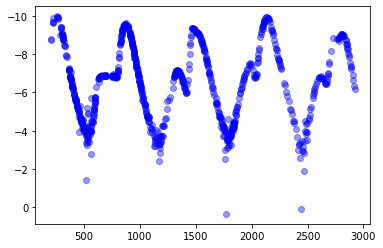

In [7]:
plt.plot(t,mag, 'bo', alpha=0.4)
plt.gca().invert_yaxis()

### Please don't connect the dots
![](bad_light_curve.png)
Actual "huh?" plot from a previous 481...

### Plotting a folded (or phased) light curve
Use the modulo ('%') function to divide out the period, leaving only remainders.

Note: I've been using this method for years, there are newer ways: 
http://docs.astropy.org/en/stable/timeseries/

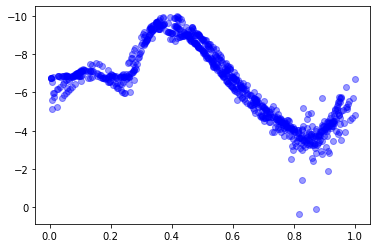

In [8]:
period = 629.8
plt.plot((t % period)/period, mag, 'bo', alpha=0.4)
plt.gca().invert_yaxis()

### The Devious Double-Folded Light Curve
This style of light curve shows two periods, which shows the structure of the light curve without abitrary endpoints, but it's devious because every data point is plotted twice...

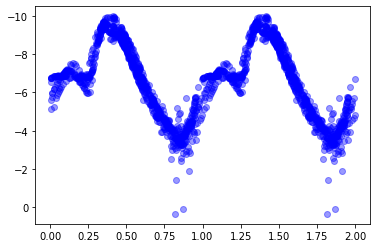

In [9]:
x = np.append( (t % period)/period, (t % period)/period + 1 )
y = np.append( mag, mag )
plt.plot( x, y, 'bo', alpha=0.4)
plt.gca().invert_yaxis()

In [17]:
""" Try it!
"""

lc = np.genfromtxt('LightCurve4.dat', names=True)
t = lc['date']
mag = lc['bmag']

# try plotting this light curve!

### Spectral Analysis of Light Curves
Real light curve data usually looks like this, but math will come to the rescue!

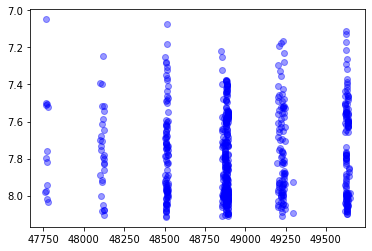

In [10]:
lc = np.genfromtxt('TU_Cas.dat', names=['date','mag'])
t = lc['date']
mag = lc['mag']

plt.plot(t,mag, 'bo', alpha=0.4)
plt.gca().invert_yaxis()

### Fourier transforms
A real Fourier code will transform the data from temporal space to frequency space; it's  equivalent to fitting sine curves at a bunch of different frequencies. The output is a *power spectrum:* how much periodicity at each frequency.

The plot below is actually a Lomb-Scargle periodigram, which for years was the only easily available fourier-based method. It's okay because we're just paying attention to the location of the highest peak, which we can then use to find a period.

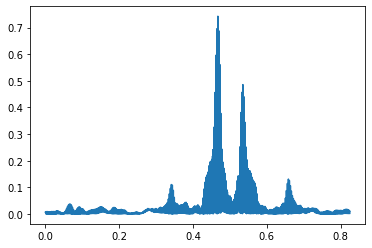

In [11]:
from astropy.timeseries import LombScargle
frequency, power = LombScargle(t, mag).autopower()
plt.plot(frequency, power)

A Lomb Scargle Periodigram is just a power spectrum scaled so the y-axis is a probability:

http://docs.astropy.org/en/stable/stats/lombscargle.html

FYI, I've been using this method for years, but there are newer ways: 

http://docs.astropy.org/en/stable/timeseries/

### Why we use Fourier Analysis

For periodic objects, the highest amplitudes of the power spectrum are the frequencies where the data actually kinda looks like a sine curve. Because a light curve can be periodic but not sine-like, in practise a Fourier transform may miss the best frequency, but is often used to generate a good initial guess for fitting.

period = 2.139280671887414


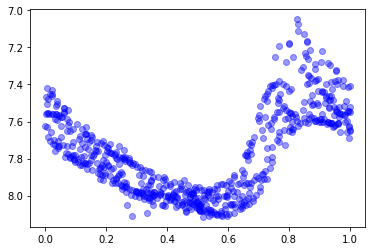

In [12]:
period = 1./frequency[np.argmax(power)] # note use of argmax()
print ("period =", period)
plt.plot((t % period)/period, mag, 'bo', alpha=0.4)
plt.gca().invert_yaxis()

In [ ]:
""" Try it!
"""

lc = np.genfromtxt('LightCurve4.dat', names=True)
t = lc['date']
mag = lc['bmag']

frequency, power = LombScargle(t, mag).autopower()
plt.plot(frequency, power)

# now comment out the power plot and copy in the ^above^ code to plot the light curve.

## Interlude: Limits on Period Finding and The Sampling Theorem

The Sampling Theorem, attributed to Claude Shannon (1949), is very useful for understanding and analyzing astronomical light curves. It defines the Nyquist Frequency (based on work by Harry Nyquist in 1928) as:

$$
f_{Nyquist} \equiv \frac{1}{2\delta}
$$

where $\delta$ is the time between evenly-spaced observations. The Nyquist frequency is a limit to what we can measure. Specifically:

1. You cannot detect frequencies above the Nyquist Frequency. 
2. But the power in those frequencies will be present ("aliased") into the range you are searching.

## Sampling Theorem Demo


Lets see how this looks. If we observe once per day, then the Nyquist limit is, 

$$
f_{Nyquist} = \frac{1}{2 \times 1} = 0.5
$$

So lets try a light curve with a frequency higher than the Nyquist frequency

$$ 
P_{Sine Wave} = 0.9 \qquad f_{Sine Wave} = 1.11 > f_{Nyquist}
$$

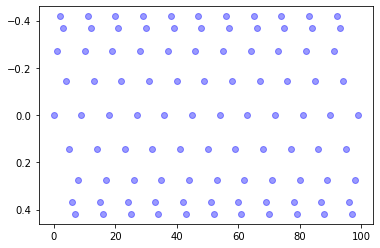

In [19]:
def Sine(t, amp = 1.0, offset = 0.0, period = 1.0, phase = 0.0):
    y = np.sin( 2*np.pi/period*(t-phase) )
    return amp/2 * y + offset

period=0.9
amp=0.85
offset = 0
phase=0.45

t = np.arange(0,100,1.) # timespan is 100 days
mag = Sine(t, amp, offset, period, phase)

plt.plot(t,mag, 'bo', alpha=0.4)
plt.gca().invert_yaxis()

Input period was 0.9 days (f = 1.1111111111111112 )
LombScargle period = 0.4739109621828626 (f = 2.11010101010101 )


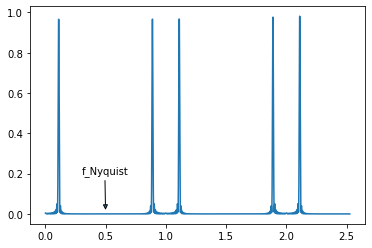

In [20]:
# http://docs.astropy.org/en/stable/stats/lombscargle.html
frequency, power =  LombScargle(t, mag).autopower()
plt.plot(frequency, power)
max_f = frequency[np.argmax(power)]
plt.annotate("f_Nyquist", xy=(0.5,0.01), xytext=(0.3, 0.2),arrowprops=dict(arrowstyle='-|>'))
#annotate("f_real", xy=(1.11+0.05,0.01), xytext=(1.21, 0.2),arrowprops=dict(arrowstyle='-|>'))
#annotate("f_LombScargle", xy=(max_f+0.05,0.01), xytext=(max_f+0.1, 0.2),arrowprops=dict(arrowstyle='-|>'))

print( "Input period was", period, "days (f =", 1/period, ")" )
lsperiod = 1./frequency[np.argmax(power)]
print( "LombScargle period =", lsperiod, "(f =", frequency[np.argmax(power)], ")" )

### Nyquist Limits

This leads to the following limits:

$$
P_{max} = \mathrm{timespan}      \qquad f_{min} =  \frac{1}{\mathrm{timespan}} 
$$
$$
P_{min} = \frac{\mathrm{timespan}}{n_{obs}/2} \qquad f_{max} = f_{Nyquist} = \frac{n_{obs}/2}{\mathrm{timespan}}
$$

(Because astronomical data is rarely taken in such a perfectly regular fashion, I find it useful to define everything in terms of the average time between observations rather than $\delta$.)



## However: Don't Worry

Astronomical data is rarely taken in a perfectly regular fashion; this ensures unequal time sampling--which collapses the uncertainty for frequencies well above the Nyquist Frequency. So, jiggle your samples around just a little bit, and you can commonly search up to $f_{max} = 10*f_{Nyquist}$.

When using a Discrete Fourier Transform method you often have to specify the spacing of the frequencies you'll search. The exact same criteria apply to $f_{\delta}$ as they did to $f_{max}$: I typically set $f_{\delta} = f_{Nyquist}/10$. A great reference to all of this is the four pages of *Numerical Recipes in C*, second edition (1992): Section  13.8: Spectral Analysis of Unevenly Sampled Data.

### A Hint

Weird results can become familier by generating the "window function". This is just what we did in this example: define a regular sine curve sampled with your data's time array, and feed that into the Fourier code. The result, which you know should have only one real peak, is the "window" through which simple sine curves are seen when sampled the same way as your data.

### Fitting Light Curves
In practise, fitting is more accurate than Fourier methods for non-sinusoidal light-curves, but since fits often require a guess, use a Fourier method to generate one!

### Example: A Challenging Light Curve:

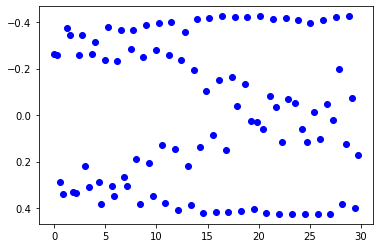

In [29]:
def add_noise(x, amp=0.1):
    return np.asarray([i + (amp*(np.random.random()-0.5)) for i in x])

# this is actually where the light "curve" gets defined
# note parameters below, both for t (observations) and Sine curve
t = add_noise(np.arange(0,30,0.31))
mag = Sine(t, amp=0.85, period=1.25, phase=0.45)
 
plt.plot(t,mag, 'bo')
plt.gca().invert_yaxis()

### Generate a guess w/ Fourier

period = 1.2462277171972587


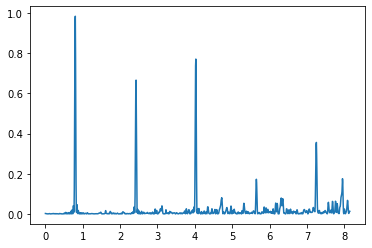

In [30]:
frequency, power = LombScargle(t, mag).autopower()
plt.plot(frequency, power)
#axis([0,0.01, 0, 0.9])
period = 1./frequency[np.argmax(power)]
print ("period =", period)

### Fit with a Sine Curve

amp = -0.8500000000185296 offset = 4.563766065136082e-11 period = 1.2499999999979208 phase = -0.17499999999248622


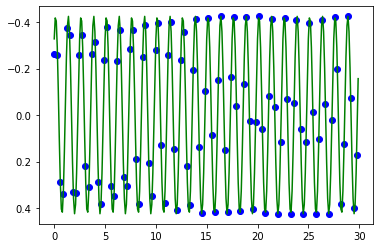

In [32]:
import scipy.optimize as optimize
# it's important to give it a good guess, 
# so put in that Lomb-Scargle period.
guess = [1,0,period,0]
fit = optimize.curve_fit(Sine, t, mag, guess)
(amp, offset, period, phase) = fit[0]
print ("amp =", amp, "offset =", offset, "period =", period, "phase =", phase)

x = np.arange(0, 30, 0.1)
plt.plot(t,mag, 'bo')
plt.plot(x, Sine(x, amp, offset, period, phase), 'g-')
plt.gca().invert_yaxis()

### Light Curve Recovered!

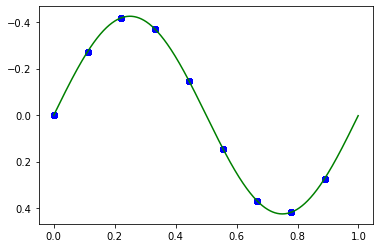

In [22]:
plt.plot((t % period)/period, mag, 'bo')
x = np.arange(0, period, period/1000) # one thousand points ought to look pretty smooth
plt.plot( x / period, Sine(x, amp, offset, period, phase), 'g-' )
plt.gca().invert_yaxis()

In [ ]:
""" Try it!
"""

lc = np.genfromtxt('LightCurve4.dat', names=True)
t = lc['date']
mag = lc['bmag']
